# From Pandas to PostgreSQL: Bulk Insert

*By Naysan Saran, May 2020.*  
Updated in June 2020, by Naysan Saran <br/>
Updated in July 2022, by Mahery Ranaivoson

## 1 - Introduction

In this tutorial we will go through all the steps required to 

- turn a csv into a pandas dataframe
- create the corresponding PostgreSQL database and table
- insert the pandas dataframe in the PostgreSQL table using different insert techniques
- benchmark them to see which one is faster

The data for this tutorial is freely available on https://datahub.io/core/global-temp, but you will also find it in the data/ directory of this github repository. What is nice about this dataframe is that it contains string, date and float columns, so it should be a good test dataframe for the benchmarking.

## 2 - From csv file to pandas dataframe

In [2]:
import pandas as pd

csv_file = "../data/global-temp-monthly.csv"
df = pd.read_csv(csv_file)
print("Total number of rows = %s" % len(df.index))
df.head(3)

Total number of rows = 3288


,Source,Date,Mean
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504


In [3]:
df = df.rename(columns={
    "Source": "source", 
    "Date": "datetime",
    "Mean": "mean_temp"
})
df.head(3)

,source,datetime,mean_temp
0,GCAG,2016-12-06,0.7895
1,GISTEMP,2016-12-06,0.8100
2,GCAG,2016-11-06,0.7504


## 3 - PostgreSQL database, table and user setup

First we create the database. I'm assuming you already have PostgreSQL installed on your system. Otherwise you can refer to this link first https://www.postgresql.org/download/.

Creating the database - Ubuntu command line instructions   

<code>>> sudo -i -u postgres</code>  
<code>>> psql</code>  
<code>postgres=# CREATE DATABASE globaldata;</code>  
<code>postgres=# \c globaldata;</code>  

For the sake of simplicity, we are going to create one table only to store everything.

<code>
postgres=# CREATE TABLE monthlytemp ( <br>
   id SERIAL PRIMARY KEY, <br>
   source VARCHAR (16) NOT NULL, <br>
   datetime DATE, <br>
   mean_temp FLOAT <br>
);
</code>

Lastly, let's create a user and give them access to our new table.

<code> 
postgres=# CREATE USER myuser WITH PASSWORD 'Passw0rd'; <br>
postgres=# GRANT SELECT, INSERT, DELETE, UPDATE on monthlytemp to myuser;
</code>

Last permission to grant, so 'myuser' can autoincrement the 'id' primary key without having to specify it

<code>
postgres=# GRANT USAGE on sequence monthlytemp_id_seq to myuser; <br>
postgres=# \q 
</code>

## 4 - Basic Python functions to access the database

Alright back to Python. Here are all the functions we will need. For a complete, functioning code, please refer to the src/ subdirectory.

In [4]:
import psycopg2
import numpy as np
import sys 
# Since we want to benchmark the efficiency of each insert strategy
from timeit import default_timer as timer

Fist, let's specify the connection parameters as a Python dictionary. The database, username and password will be the same that we created in part 3.

In [5]:
param_dic = {
    "host"      : "localhost",
    "database"  : "globaldata",
    "user"      : "myuser",
    "password"  : "Passw0rd",
    "port"      : 5432
}

This function will allow us to connect to the database

In [6]:
def connect(params_dic):
    """ Connect to the PostgreSQL database server """
    conn = None
    try:
        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(**params_dic)
        conn.autocommit = True
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
        sys.exit(1) 
    print("Connection successful")
    return conn


Testing the database connection

In [7]:
conn = connect(param_dic)

Connecting to the PostgreSQL database...
Connection successful


Function to execute any query in the database. Will come in handy later as we test multiple insert tactics.

In [8]:
def execute_query(conn, query):
    """ Execute a single query """
    
    ret = 0 # Return value
    cursor = conn.cursor()
    try:
        cursor.execute(query)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1

    # If this was a select query, return the result
    if 'select' in query.lower():
        ret = cursor.fetchall()
    cursor.close()
    return ret

## Comparing the Bulk Insert Strategies

### A - ExecuteMany

In [9]:
def execute_many(conn, df, table):
    """
    Using cursor.executemany() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        cursor.executemany(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_many() done")
    cursor.close()

# Run the execute_many strategy
execute_many(conn, df, 'monthlytemp')

execute_many() done


In [10]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [11]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### B - ExecuteBatch

In [12]:
import psycopg2.extras as extras

def execute_batch(conn, df, table, page_size=100):
    """
    Using psycopg2.extras.execute_batch() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES(%%s,%%s,%%s)" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_batch(cursor, query, tuples, page_size)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_batch() done")
    cursor.close()


# Run the execute_many strategy
execute_batch(conn, df, 'monthlytemp')

execute_batch() done


In [13]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [14]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### C - ExecuteValues

In [15]:
def execute_values(conn, df, table):
    """
    Using psycopg2.extras.execute_values() to insert the dataframe
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    query  = "INSERT INTO %s(%s) VALUES %%s" % (table, cols)
    cursor = conn.cursor()
    try:
        extras.execute_values(cursor, query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_values() done")
    cursor.close()


# Run the execute_many strategy
execute_values(conn, df, 'monthlytemp')

execute_values() done


In [16]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [17]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### D - Mogrify() then execute()

In [18]:
def execute_mogrify(conn, df, table):
    """
    Using cursor.mogrify() to build the bulk insert query
    then cursor.execute() to execute the query
    """
    # Create a list of tupples from the dataframe values
    tuples = [tuple(x) for x in df.to_numpy()]
    # Comma-separated dataframe columns
    cols = ','.join(list(df.columns))
    # SQL quert to execute
    cursor = conn.cursor()
    values = [cursor.mogrify("(%s,%s,%s)", tup).decode('utf8') for tup in tuples]
    query  = "INSERT INTO %s(%s) VALUES " % (table, cols) + ",".join(values)
    
    try:
        cursor.execute(query, tuples)
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("execute_mogrify() done")
    cursor.close()


# Run the execute_many strategy
execute_mogrify(conn, df, 'monthlytemp')

execute_mogrify() done


In [19]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [20]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### E - CopyFrom() - Save to disk first

In [21]:
import os

def copy_from_file(conn, df, table):
    """
    Here we are going save the dataframe on disk as 
    a csv file, load the csv file  
    and use copy_from() to copy it to the table
    """
    # Save the dataframe to disk
    tmp_df = "./tmp_dataframe.csv"
    df.to_csv(tmp_df, index_label='id', header=False)
    f = open(tmp_df, 'r')
    cursor = conn.cursor()
    try:
        cursor.copy_from(f, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        os.remove(tmp_df)
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("copy_from_file() done")
    cursor.close()
    os.remove(tmp_df)


# Run the execute_many strategy
copy_from_file(conn, df, 'monthlytemp')

copy_from_file() done


In [22]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [23]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### F - CopyFrom() - In memory using StringIO

In [24]:
from io import StringIO

def copy_from_stringio(conn, df, table):
    """
    Here we are going save the dataframe in memory 
    and use copy_from() to copy it to the table
    """
    # save dataframe to an in memory buffer
    buffer = StringIO()
    df.to_csv(buffer, index_label='id', header=False)
    buffer.seek(0)
    
    cursor = conn.cursor()
    try:
        cursor.copy_from(buffer, table, sep=",")
        conn.commit()
    except (Exception, psycopg2.DatabaseError) as error:
        print("Error: %s" % error)
        conn.rollback()
        cursor.close()
        return 1
    print("copy_from_stringio() done")
    cursor.close()


# Run the execute_many strategy
copy_from_stringio(conn, df, 'monthlytemp')

copy_from_stringio() done


In [25]:
# Check that the values were indeed inserted
execute_query(conn, "select count(*) from monthlytemp;")

[(3288,)]

In [26]:
# Clear the table
execute_query(conn, "delete from monthlytemp where true;")

0

### G - to_sql() - From sqlalchemy

Because we are using a different library to connect to the database (SqlAlchemy), we have to connect again.

In [27]:
from sqlalchemy import create_engine

connect = "postgresql+psycopg2://%s:%s@%s:5432/%s" % (
    param_dic['user'],
    param_dic['password'],
    param_dic['host'],
    param_dic['database']
)

def to_sql(df):
    """
    Using a dummy table to test this call library
    """
    engine = create_engine(connect)
    df.to_sql(
        name='to_sql_table', 
        con=engine, 
        index=False, 
        if_exists='replace'
    )
    print("to_sql() done")
    
to_sql(df)

to_sql() done


In [28]:
execute_query(conn, "select count(*) from to_sql_table;")

[(3288,)]

In [29]:
# Clear the table
execute_query(conn, "delete from to_sql_table where true;")

0

### H - to_sql() having method 

In [30]:
from sqlalchemy import create_engine
import csv

connect = "postgresql+psycopg2://%s:%s@%s:5432/%s" % (
    param_dic['user'],
    param_dic['password'],
    param_dic['host'],
    param_dic['database']
)

def psql_insert_copy(table, conn, keys, data_iter):
    """
    Execute SQL statement inserting data

    Parameters
    ----------
    table : pandas.io.sql.SQLTable
    conn : sqlalchemy.engine.Engine or sqlalchemy.engine.Connection
    keys : list of str
        Column names
    data_iter : Iterable that iterates the values to be inserted
    """
    # gets a DBAPI connection that can provide a cursor
    dbapi_conn = conn.connection
    with dbapi_conn.cursor() as cur:
        s_buf = StringIO()
        writer = csv.writer(s_buf)
        writer.writerows(data_iter)
        s_buf.seek(0)

        columns = ', '.join(['"{}"'.format(k) for k in keys])
        if table.schema:
            table_name = '{}.{}'.format(table.schema, table.name)
        else:
            table_name = table.name

        sql = 'COPY {} ({}) FROM STDIN WITH CSV'.format(
            table_name, columns)
        cur.copy_expert(sql=sql, file=s_buf)
        
def to_sql_method(df):
    """
    Using a dummy table to test this call library
    """
    engine = create_engine(connect)
    
    df.to_sql(
        name="to_sql_method_table",
        con=engine,
        if_exists="replace",
        index=False,
        method=psql_insert_copy
    )
    
    print("to_sql_method() done ")
    
to_sql_method(df)

to_sql_method() done 


In [31]:
execute_query(conn, "select count(*) from to_sql_method_table;")

[(3288,)]

In [32]:
# Clear the table
execute_query(conn, "delete from to_sql_method_table where true;")

0

# Benchmarking the performance of each strategy

In [33]:
def single_inserts(conn, df, table):
    """
    For benchmarking purposes, let's also implement a strategy in 
    which the inserts calls are done separately. Here we are 
    creating and closing a new cursor at each time, so this is probably 
    one of the slowest ways to achieve what we want.
    """
    for i in df.index:
        cols  = ','.join(list(df.columns))
        vals  = [df.at[i,col] for col in list(df.columns)]
        query = "INSERT INTO %s(%s) VALUES('%s','%s',%s)" % (table, cols, vals[0], vals[1], vals[2])
        execute_query(conn, query)
    print("single_inserts() done")
        
        
#-----------------------------------------
# COMPARE THE SPEED OF EACH STRATRGY
#-----------------------------------------
def benchmark_bulk_inserts(df):
    execute_query(conn, "delete from monthlytemp where true;")
    functions = [
        single_inserts, 
        execute_many, 
        execute_batch,
        execute_values, 
        execute_mogrify, 
        copy_from_file,
        copy_from_stringio
    ]
    exec_times = pd.DataFrame(index=range(len(functions)), columns=['nrows','strategy','time'])

    # Psycop2's functions
    i = 0
    for strategy in functions:
        start = timer()
        strategy(conn, df, 'monthlytemp')
        end = timer()
        
        exec_times.at[i,'nrows'] = len(df.index)
        exec_times.at[i,'strategy'] = strategy.__name__
        exec_times.at[i,'time'] = end-start
        
        # Prepare for the next test
        execute_query(conn, "delete from monthlytemp where true;")
        i = i + 1

    # Adding an extra test case for a simple to_sql
    start = timer()
    to_sql(df)
    end = timer()
    exec_times.at[i,'nrows'] = len(df.index)
    exec_times.at[i,'strategy'] = "to_sql without method"
    exec_times.at[i,'time'] = end-start
    
    # Adding an extra test case for to_sql with the method parameter
    start = timer()
    to_sql_method(df)
    end = timer()
    exec_times.at[i+1,'nrows'] = len(df.index)
    exec_times.at[i+1,'strategy'] = "to_sql with method"
    exec_times.at[i+1,'time'] = end-start
    
    return exec_times

benchmark_bulk_inserts(df)

single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
copy_from_file() done
copy_from_stringio() done
to_sql() done
to_sql_method() done 


,nrows,strategy,time
0,3288,single_inserts,2.24721
1,3288,execute_many,2.06481
2,3288,execute_batch,0.144675
3,3288,execute_values,0.054586
4,3288,execute_mogrify,0.0410052
5,3288,copy_from_file,0.0159291
6,3288,copy_from_stringio,0.0170984
7,3288,to_sql without method,0.327527
8,3288,to_sql with method,0.0348193


## Trying with 1000 to 100,000 rows

In [34]:
# Repeating our dataframe 30 times to get a large test dataframe
big_df = pd.concat([df]*31, ignore_index=True)
print(len(big_df.index))

101928


In [35]:
df_lst = []

for nrows in [1000,10000,50000,100000]:
    print("Nrows = %s" % nrows)
    test_df = big_df[0:nrows]
    perf_df = benchmark_bulk_inserts(test_df)
    df_lst.append(perf_df)
    

performances = pd.concat(df_lst, axis=0).reset_index()
performances.head(3)

Nrows = 1000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
copy_from_file() done
copy_from_stringio() done
to_sql() done
to_sql_method() done 
Nrows = 10000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
copy_from_file() done
copy_from_stringio() done
to_sql() done
to_sql_method() done 
Nrows = 50000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
copy_from_file() done
copy_from_stringio() done
to_sql() done
to_sql_method() done 
Nrows = 100000
single_inserts() done
execute_many() done
execute_batch() done
execute_values() done
execute_mogrify() done
copy_from_file() done
copy_from_stringio() done
to_sql() done
to_sql_method() done 


,index,nrows,strategy,time
0,0,1000,single_inserts,0.537661
1,1,1000,execute_many,0.423492
2,2,1000,execute_batch,0.0457056


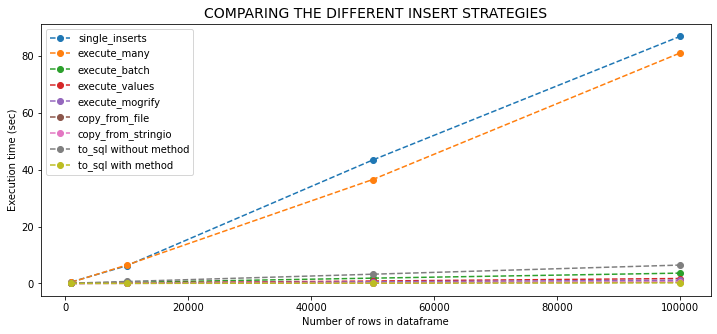

In [36]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    subset = performances[performances['strategy'] == strategy]
    ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE DIFFERENT INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./all_insert_strategies.png", dpi=400)
plt.show()

### CONCLUSION 1
If you care about speed, avoid doing single inserts at all costs.

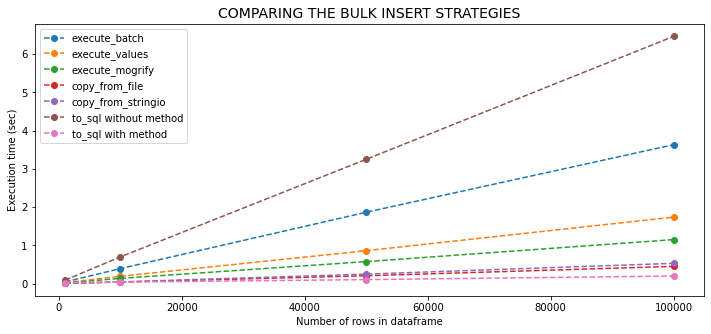

In [38]:
fig, ax = plt.subplots(figsize=(12,5))
for strategy in performances['strategy'].unique():
    if (strategy != 'single_inserts') and (strategy != 'execute_many'):
        subset = performances[performances['strategy'] == strategy]
        ax.plot(subset['nrows'], subset['time'], 'o--', label=strategy)

plt.xlabel('Number of rows in dataframe')
plt.ylabel('Execution time (sec)')
plt.title("COMPARING THE BULK INSERT STRATEGIES", fontsize=14)
plt.legend()
plt.savefig("./benchmark.png", dpi=400)
plt.show()

### CONCLUSION 2

So **execute_values()** and **execute_mogrify()** are doing fine...but the fastest way is to use **copy_from**. You can either  
  * save your dataframe to a stringio object and load it directly to SQL, or
  * save your dataframe to disk and load it to SQL
  
I don't know about you, but it is kind of sad to see that a good old copy is doing a better job than execute_values() and execute_mogrify()... But sometimes low tech is best.

### CONCLUSION 3 - Mahery Ranaivoson 

* In this update, I added one more bulk insert strategy in this notebook. It is nothing but the **to_sql()** function but with th parameter *method* initialized. 
* I repeat the experiment several times and I found that **execute_values()** and **single_inserts()** have almost the same performance. The reason may the update on these function. 
* By the way, the strategy I introduce outperforms all the common strategies detailed in this notebook. For more detail regarding teh strategy, please refer to the official pandas doc [here](https://pandas.pydata.org/docs/user_guide/io.html#io-sql-method)